# COGS 108 - EDA Checkpoint

# Names

- Bridget Egan 
- Dillan Merchant
- Jennifer Hang
- Sam Zakeri
- Connie Chang

# Research Question

**How are American news headline sentiments correlated to their publication source's political leanings?** To do this, we wanted three sources that reflected 'far-left', 'centrist', and 'far-right' political leanings. Using both AllSides and MediaBiasFactCheck, Breitbart was evaluated as the most right-leaning news source of our dataset, CNN was evaluated as the most left-leaning news source, and NPR was evaluated as the most politically-centrist news source [1, 2, 3, 4, 5, 6, 7]. *We hypothesize that the two more politically polar news sources, Breitbart and CNN, will have more polar sentiment (as in frequently positive or negative-- bimodal distribution), and the more centrist news source, NPR, will be more neutral in sentiment.*
- [1] https://www.allsides.com/news-source/cnn-media-bias
- [2] https://mediabiasfactcheck.com/cnn/
- [3] https://mediabiasfactcheck.com/npr/
- [4] https://www.allsides.com/news-source/npr-media-bias
- [5] https://www.allsides.com/news-source/breitbart
- [6] https://mediabiasfactcheck.com/breitbart/
- [7] https://www.adfontesmedia.com/static-mbc/

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk import word_tokenize, sent_tokenize, tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon') 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/began/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Data Cleaning

The data is fairly clean to begin with, there are few missing values and the format is consistent throughout. The issue we have is there is a lot of data that we do not need to use. So, to get our data into a useable format, we will only select the three publications we plan to use, Breitbart, CNN, and NPR, and keep the dates and headlines from only 1,000 of each. We decided on 1,000 of each because the dataset had a higher number of Breitbart articles than any other publication, and we wanted there to be a standard number of headlines for each source. Given that we plan on doing the additional step of sentiment analysis after this data checkpoint, most of our EDA will come next week, and so data distribution checking or data transformations will not be necessary at this time. It is also possible that as this project proceeds, we may decide to add in more points of data analysis, such as increasing how many articles we analyze from each news source, or even adding in different news sources to give us data for a 'center-right' and 'center-left source', if we feel that would improve the strength of our project.

In [2]:
#this imports the relevant data sets from three separate files, and sanitizes the input.

news1 = pd.read_csv('csv_files/articles1.csv', engine = 'python', error_bad_lines=False)
news2 = pd.read_csv('csv_files/articles2.csv', engine = 'python', error_bad_lines=False)
news3 = pd.read_csv('csv_files/articles3.csv', engine = 'python', error_bad_lines=False)


print(news1.shape)
print(news2.shape)
print(news3.shape)

Skipping line 17535: field larger than field limit (131072)
Skipping line 1429: field larger than field limit (131072)
Skipping line 1469: field larger than field limit (131072)
Skipping line 1516: field larger than field limit (131072)
Skipping line 1740: field larger than field limit (131072)
Skipping line 3774: field larger than field limit (131072)
Skipping line 3779: field larger than field limit (131072)
Skipping line 3791: field larger than field limit (131072)
Skipping line 33121: field larger than field limit (131072)
Skipping line 34127: field larger than field limit (131072)


(49999, 10)
(49992, 10)
(42569, 10)


In [3]:
# combine three dataframes into one
news = news1.append(news2).append(news3)
news.shape

(142560, 10)

In [4]:
# check number of articles for each source
news['publication'].value_counts()

Breitbart              23780
New York Post          17493
NPR                    11992
CNN                    11488
Washington Post        11112
Reuters                10710
Guardian                8681
New York Times          7803
Atlantic                7172
Business Insider        6757
National Review         6203
Talking Points Memo     5214
Vox                     4947
Buzzfeed News           4854
Fox News                4354
Name: publication, dtype: int64

In [5]:
#But we only care about the article title, where it comes from, and when it was published(for context of the news)

news_cleaned = news[['title', 'publication', 'date']]
news_cleaned.head()

,title,publication,date
0,House Republicans Fret About Winning Their Hea...,New York Times,2016-12-31
1,Rift Between Officers and Residents as Killing...,New York Times,2017-06-19
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,2017-01-06
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,2017-04-10
4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,2017-01-02


In [6]:
#Getting rid of all the null columns
news_cleaned = news_cleaned.dropna()
news_cleaned.isnull().values.any()

False

In [7]:
# keep news only from 'Breitbart', 'CNN', and 'NPR'
sources = ['Breitbart', 'CNN', 'NPR']
news = news_cleaned[news_cleaned['publication'].isin(sources)]

news['publication'].value_counts()

Breitbart    23780
NPR          11992
CNN          11488
Name: publication, dtype: int64

In [8]:
# pick 1000 random news for each source
news = news.groupby("publication").sample(n=1000)

news['publication'].value_counts()

NPR          1000
CNN          1000
Breitbart    1000
Name: publication, dtype: int64

In [9]:
news.head()

,title,publication,date
19375,How Ted Cruz Can Win Iowa - Breitbart,Breitbart,2016-01-24
26067,Driver Threatened with Chainsaw During Calais ...,Breitbart,2016-08-02
30307,CA Lawmakers Designate $5 Million for ’Firearm...,Breitbart,2016-06-20
18247,Fraternal Order of Police Endorse Donald Trump...,Breitbart,2016-09-17
16431,GOP Veepstakes Begin: Candidates Start Buildin...,Breitbart,2016-04-22


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [10]:
news['title'] = news['title'].astype(str)

## Lowercase
news['title'] = news['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#remove punct
def remove_punct(string):
    punctuation= '''‘’!()-[]{};:'", <>./?@#$%^&*_~'''
    for x in punctuation:
        string = string.replace(x, " ")
    return string

news['title'] = news['title'].apply(remove_punct)

#tokenize 
news['title'] = news['title'].apply(word_tokenize)

## stop word removal
stop_words = set(stopwords.words('english'))


#We see in the data that Breitbart includes the name of their publication at the end of each of their article titles, as such,
#we decided to add 'breitbart' as a stop word so that it would be removed from the titles, and not dilute the sentiment of the rest
#of the article titles.
stop_words.add('breitbart, washington')
news['title'] = news['title'].apply(lambda x: [item for item in x if item not in stop_words])


##stemming
stemmer = PorterStemmer()
news['title'] = news['title'].apply(lambda x: [stemmer.stem(y) for y in x])

news['tokenized_list'] = news['title']

# putting the tokenized, stemmed, and cleaned titles back into lists
def joiner(title_list): 
    return ' '.join(title_list)
news['title'] = news['title'].apply(joiner)


#Analysing the sentiment of each title and creating a new Dataframe of the compound of the sentiments
analyser = SentimentIntensityAnalyzer()
title_sentences = list(news['title'])
def senti(input_list):
    output = pd.DataFrame()
    for sentence in title_sentences:
        ss = analyser.polarity_scores(sentence)
        ss['cleaned_titles'] = sentence
        output = output.append(ss, ignore_index=True)
    return output


news_sentiments = senti(title_sentences)


In [11]:
#creating a combined dataframe of the titles, their publications, and the compound sentiment of their titles. 
news_sentiments
title_sentiments = pd.DataFrame(news_sentiments['compound']) 

title_sentiments
news = news.reset_index()
news['title_sentiment']  = news_sentiments['compound']
news

,index,title,publication,date,tokenized_list,title_sentiment
0,19375,ted cruz win iowa breitbart,Breitbart,2016-01-24,"[ted, cruz, win, iowa, breitbart]",0.5859
1,26067,driver threaten chainsaw calai night violenc,Breitbart,2016-08-02,"[driver, threaten, chainsaw, calai, night, vio...",-0.3818
2,30307,ca lawmak design 5 million firearm violenc res...,Breitbart,2016-06-20,"[ca, lawmak, design, 5, million, firearm, viol...",0.0000
3,18247,fratern order polic endors donald trump breitbart,Breitbart,2016-09-17,"[fratern, order, polic, endors, donald, trump,...",0.0000
4,16431,gop veepstak begin candid start build list vet...,Breitbart,2016-04-22,"[gop, veepstak, begin, candid, start, build, l...",0.2960
...,...,...,...,...,...,...
2995,12003,hh report say obamacar plan cheaper look,NPR,2016-07-12,"[hh, report, say, obamacar, plan, cheaper, look]",0.0000
2996,7765,doctor wrote 1980 letter painkil regret fed op...,NPR,2017-06-16,"[doctor, wrote, 1980, letter, painkil, regret,...",-0.4215
2997,7341,power new ebola vaccin head congo help stop ou...,NPR,2017-05-30,"[power, new, ebola, vaccin, head, congo, help,...",0.1280
2998,15072,long unseen reader h g well ghost stori final ...,NPR,2016-11-27,"[long, unseen, reader, h, g, well, ghost, stor...",-0.0516


### Let us first start with a general exploration of the average sentiments of each news source. 

In [12]:
news['title_sentiment'].describe()

count    3000.000000
mean       -0.088137
std         0.355948
min        -0.943200
25%        -0.340000
50%         0.000000
75%         0.000000
max         0.895700
Name: title_sentiment, dtype: float64

In [13]:
news[news['publication'] == 'Breitbart']['title_sentiment'].describe()

count    1000.000000
mean       -0.131097
std         0.366770
min        -0.943200
25%        -0.401900
50%         0.000000
75%         0.000000
max         0.883400
Name: title_sentiment, dtype: float64

In [14]:
news[news['publication'] == 'CNN']['title_sentiment'].describe()

count    1000.000000
mean       -0.108678
std         0.336842
min        -0.916900
25%        -0.340000
50%         0.000000
75%         0.000000
max         0.743000
Name: title_sentiment, dtype: float64

In [15]:
news[news['publication'] == 'NPR']['title_sentiment'].describe()

count    1000.000000
mean       -0.024637
std         0.355051
min        -0.904200
25%        -0.226300
50%         0.000000
75%         0.000000
max         0.895700
Name: title_sentiment, dtype: float64

### The average total mean of the sentiment distribution is negative, which is to be expected. But of the news sources, CNN is the most negative, on average with a mean sentiment of around -0.24, and NPR is the most neutral, with an average sentiment of -0.08. Breitbart sits slighly more positive than CNN with an average sentiment of -0.2. But the data could benefit from visual representation. 

### Here begins the visual EDA, with histograms of combined sentiment of all the news sources, then from each specific publication. 

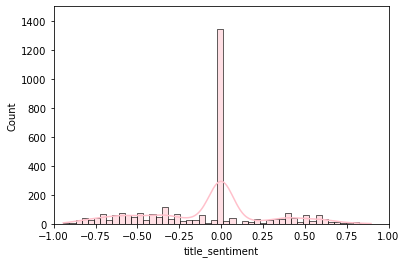

In [16]:
total_plot = sns.histplot(news['title_sentiment'], bins=50, kde=True, color = 'pink');

total_plot.set(ylim=(0,1500));
total_plot.set(xlim=(-1,1));

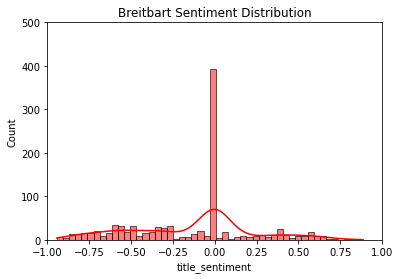

In [17]:
#creating a histogram plot of sentiment distribution based on the composite sentiment 
breitbart = news[news['publication'] == 'Breitbart']
# breitbart.reset_index();
breitbart_plot = sns.histplot(breitbart['title_sentiment'], bins=50, kde=True, color = 'red')

breitbart_plot.set_title("Breitbart Sentiment Distribution")
breitbart_plot.set(ylim=(0,500))
breitbart_plot.set(xlim=(-1,1));

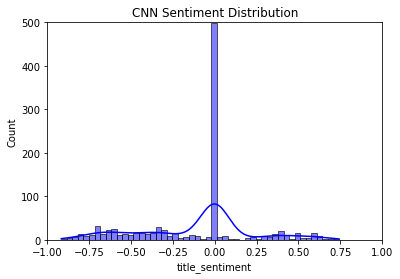

In [18]:
cnn = news[news['publication'] == 'CNN']
# cnn.reset_index();
cnn_plot = sns.histplot(cnn['title_sentiment'], bins=50, kde=True, color = 'blue');

cnn_plot.set_title("CNN Sentiment Distribution");
cnn_plot.set(ylim=(0,500));
cnn_plot.set(xlim=(-1,1));

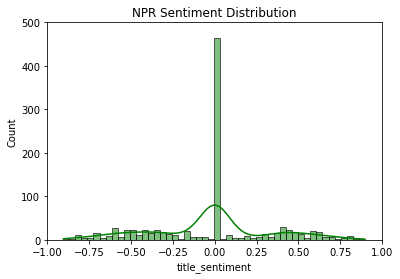

In [19]:
npr = news[news['publication'] == 'NPR']
npr_plot = sns.histplot(npr['title_sentiment'], bins=50, kde=True, color = 'green');

npr_plot.set_title("NPR Sentiment Distribution");
npr_plot.set(ylim=(0,500));
npr_plot.set(xlim=(-1,1));

### For all of these graphs, we can see an obvious similarity, the large column of zero sentiments in the middle. Is this is indicative of the writers of these publications clearly trying to craft the most neutral titles as possible? Or is it that many headlines have complete neutral sentiment due to errors in the stemmer and uses of names? 

### To view the data with a more critical lens, we decided to remove all of the zero sentiments from each of the titles across the board. It is important to note that both NPR and CNN have nearly a hundred more 0 sentiment titles than Breitbart, but we feel that the data can be analyzed adequately without the large column in the middle, and will be able to see the general skew of articles that have more polar sentiment.

In [20]:
#get rid of 0 values (outlier)
news = news[news.title_sentiment != 0]
news.head()
##Pay attention to the words that are not stemmed properly!!

,index,title,publication,date,tokenized_list,title_sentiment
0,19375,ted cruz win iowa breitbart,Breitbart,2016-01-24,"[ted, cruz, win, iowa, breitbart]",0.5859
1,26067,driver threaten chainsaw calai night violenc,Breitbart,2016-08-02,"[driver, threaten, chainsaw, calai, night, vio...",-0.3818
4,16431,gop veepstak begin candid start build list vet...,Breitbart,2016-04-22,"[gop, veepstak, begin, candid, start, build, l...",0.2960
5,17867,itali deport jihadist suspect plot attack lean...,Breitbart,2016-08-13,"[itali, deport, jihadist, suspect, plot, attac...",-0.6486
6,28642,glenn beck defend mark zuckerberg attack conserv,Breitbart,2016-05-19,"[glenn, beck, defend, mark, zuckerberg, attack...",-0.4767


In [21]:
breitbart = news[news['publication'] == 'Breitbart']
cnn = news[news['publication'] == 'CNN']
npr = news[news['publication'] == 'NPR']

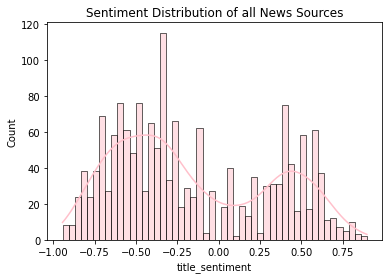

In [22]:
total_plot = sns.histplot(news['title_sentiment'], bins=50, kde=True, color = 'pink');

total_plot.set_title("Sentiment Distribution of all News Sources");

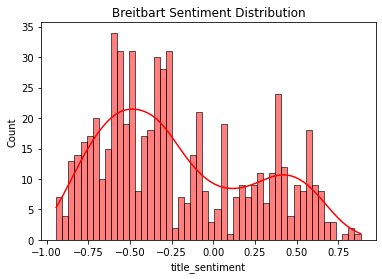

In [23]:
breitbart_plot = sns.histplot(breitbart['title_sentiment'], bins=50, kde=True, color = 'red')

breitbart_plot.set_title("Breitbart Sentiment Distribution");

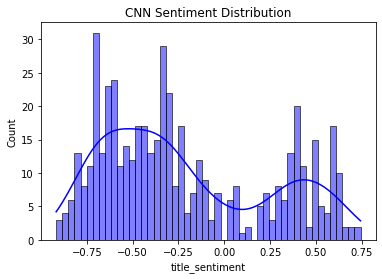

In [24]:
cnn_plot = sns.histplot(cnn['title_sentiment'], bins=50, kde=True, color = 'blue');

cnn_plot.set_title("CNN Sentiment Distribution");

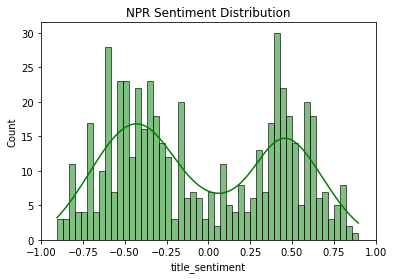

In [25]:
npr_plot = sns.histplot(npr['title_sentiment'], bins=50, kde=True, color = 'green');

npr_plot.set_title("NPR Sentiment Distribution");
npr_plot.set(xlim=(-1,1));

### By removing the column in the middle, we can see a clearer pattern emerge. All of the news sources have a more obvious bimodal distribution. But Breitbart and CNN seem to have a skew. We will now combine the graphs to compare the general sentiment distribution of each source.

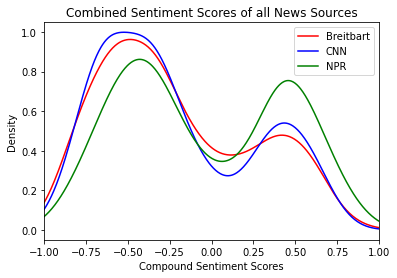

In [26]:
#To combine all the sentiment scores without the 0 sentiment data. 
breitbart = news[news['publication'] == 'Breitbart']
cnn = news[news['publication'] == 'CNN']
npr = news[news['publication'] == 'NPR']

Breitbart = list(breitbart['title'].values)
CNN = list(cnn['title'].values)
NPR = list(npr['title'].values)


# function that will output the dataframe that stores sentiment information
def get_sentiments(input_list):
    output = pd.DataFrame()
    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        output = output.append(ss, ignore_index=True)
    return output

breitbart_sentiments = get_sentiments(Breitbart)
breitbart_sentiments['compound'].plot.density(color = 'red', label = 'Breitbart')

cnn_sentiments = get_sentiments(CNN)
cnn_sentiments['compound'].plot.density(color = 'blue', label = 'CNN')

npr_sentiments = get_sentiments(NPR)
npr_sentiments['compound'].plot.density(color = 'green', label = 'NPR')


plt.legend(loc = 'upper right')
plt.xlabel('Compound Sentiment Scores')
plt.xlim(-1,1);
plt.title("Combined Sentiment Scores of all News Sources");

### By showing all the news sentiment scores on one graph, we can clearly see that CNN and Breitbart have a distint rightward skew, meaning that the average sentiment of their article titles is more negative than positive. This is in contrast to NPR, which shows a more balanced bimodal distribution with no clear skew to the left or to the right. CNN seems to be slightly more negative than Breitbart. 


### But we should still ask the question, which words show up the most for all the publications, for each individual publication? Will these words be more negative, positive, or neutral? To do this, we will take the stemmed and stop word cleaned titles and look at them for the top word frequencies.

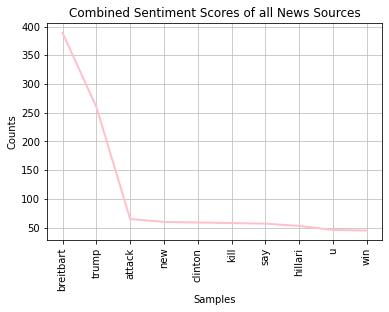

In [27]:
combined_news_publications = news['tokenized_list'].apply(pd.Series).stack()
# calculation word frequency
fdist_most = FreqDist(combined_news_publications)

# remove punctuation counts
for punc in string.punctuation:
    del fdist_most[punc]

# Frequency Distribution Plot - top 10 most common words
fdist_most.plot(10, cumulative=False, color = 'pink', title = 'Combined Sentiment Scores of all News Sources');

In [28]:
totalNPR = news['tokenized_list'][(news['publication'] == 'NPR')].apply(pd.Series).stack()
totalCNN = news['tokenized_list'][(news['publication'] == 'CNN')].apply(pd.Series).stack()
totalBreitbart = news['tokenized_list'][(news['publication'] == 'Breitbart')].apply(pd.Series).stack()

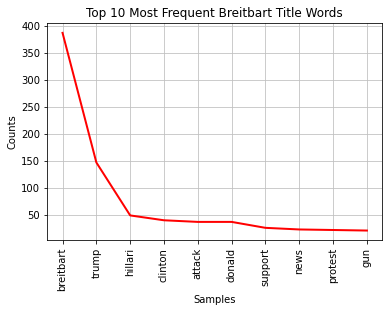

In [29]:
fdist_most = FreqDist(totalBreitbart) 
for punc in string.punctuation:
    del fdist_most[punc]
fdist_most.plot(10, cumulative=False, color = 'red', title = 'Top 10 Most Frequent Breitbart Title Words');

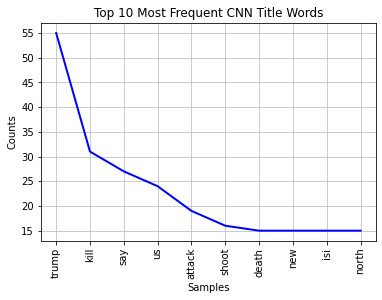

In [30]:
fdist_most = FreqDist(totalCNN) 
for punc in string.punctuation:
    del fdist_most[punc]
fdist_most.plot(10, cumulative=False, color = 'blue', title = 'Top 10 Most Frequent CNN Title Words');

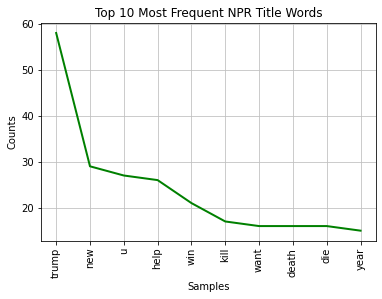

In [31]:
fdist_most = FreqDist(totalNPR) 
for punc in string.punctuation:
    del fdist_most[punc]
fdist_most.plot(10, cumulative=False, color = 'green', title = 'Top 10 Most Frequent NPR Title Words');

### We can see from these most frequent words that the name "Trump" is the most common word used across the publications, which can be ascribed to the time in which the data was collected, starting from the election of 2016 and through his presidency. The rest of the distributions seem to show a propensity for negative words, such as 'kill', 'die', 'attack', and 'death', which can be ascribed to the fact that news outlets will often over-report serious violent events. "Though, it should be noted that NPR seems to have these words further down the list, and CNN has the highest frequency of these 'violent' words. 


### As for our original hypothesis: 
"*We hypothesize that the two more politically polar news sources, Breitbart and CNN, will have more polar sentiment (as in frequently positive or negative-- bimodal distribution), and the more centrist news source, NPR, will be more neutral in sentiment.*" 
### We feel that our data does support our hypothesis partially, we origianlly did predict that CNN and Breitbart would have a strong bimodal distribution, due to the likely more policially polar nature of their material, and that NPR would be thoroughly neutral, as it is in its political description. NPR did end up being visibly more neutral than the other two, which, while having a bimodal distribution, were both strongly skewed to the left. "

#### As for our future steps, we plan to do further significance evaluation of our sentiment variable, and clean up some of our graphical representation, possibly combining a few to be more consise. 

_______________________________________________